# REMCMC benchmark

エネルギーが
$$f(x)=\frac12\sum_{i=1}^d (x_i^4-16x_i^2+5x_i)$$
の関数(["STYBLINSKI-TANG FUNCTION"](https://www.sfu.ca/~ssurjano/stybtang.html))のサンプリング  
すなわち確率分布
$$p(x)=\frac{\exp[-f(x)]}{\int \exp[-f(x)] dx} $$
のサンプリング．

大域最小解は
$$f(x^*)=-39.16599d,\; \text{at}\; x^*=(-2.9035,\dots,-2.9035)$$
$\{-2.9035, 2.74680\}^d$の複数地点で極小値があり，局所最適化では大域解を求めづらい関数．

$d=3$次元でテスト．
```bash
$ python remcmc_bench.py > sampling_log.txt
```
で通常のM-HアルゴリズムとReplica Exchangeでのサンプリング結果を`test_mhmcmc_*.bin`と`test_remcmc_*.bin`に保存．

In [1]:
import pickle
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

真の関数形

In [2]:
def f(x):
    Z = 4.38002*10**16
    return np.exp(-1/2*(x**4-16*x**2+5*x))/Z

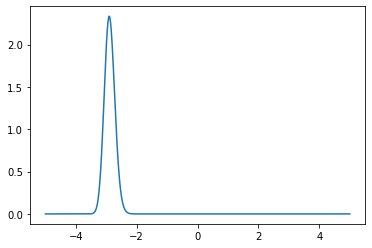

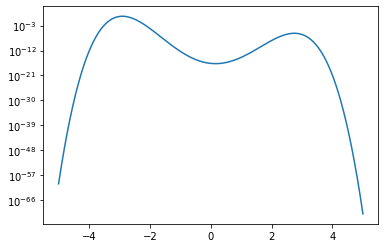

In [3]:
plt.plot(
    np.linspace(-5, 5, 1000),
    f(np.linspace(-5,5,1000))
)
#plt.yscale('log')
plt.show()
plt.plot(
    np.linspace(-5, 5, 1000),
    f(np.linspace(-5,5,1000))
)
plt.yscale('log')
plt.show()

## M-Hアルゴリズム

初期値は $\mathcal{N}(0,10^2)$ でランダムに取る．

In [4]:
data_s = []
for file_name in glob.glob("test_mhmcmc_*.bin"):
    with open(file_name, mode="rb") as file:
        data_s += [pickle.load(file)]

In [5]:
data_s[0].keys()

dict_keys(['param_name_j', 'beta_k', 'eps_j_k', 'exchange_step', 'accept_j_n_k', 'exchange_accept_n_k', 'sample_j_n_k', 'lcp_sample_n_k', 'lpp_sample_n_k', 'll_sample_n_k'])

In [6]:
n_chain = len(data_s)
sample_j_n_k_c = np.array([data_s[chain]["sample_j_n_k"] for chain in range(n_chain)])

In [7]:
burnin = 5000
skip = 3

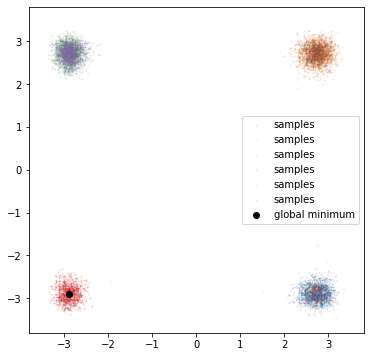

In [8]:
plt.figure(figsize=(6,6))
for chain in range(n_chain):
    plt.scatter(
        sample_j_n_k_c[chain, 0, burnin::skip, 0],
        sample_j_n_k_c[chain, 0, burnin::skip, 1],
        s=1, alpha=0.1, label="samples"
    )
plt.scatter([-2.903534], [-2.903534], c="k", label="global minimum")
lim = abs(np.array([*plt.xlim(), *plt.ylim()])).max()
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.legend()
plt.show()

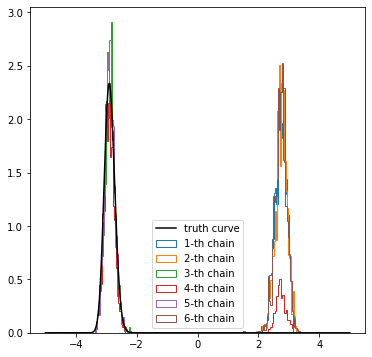

In [9]:
plt.figure(figsize=(6,6))
for chain in range(n_chain):
    plt.hist(
        sample_j_n_k_c[chain, 0, burnin::skip, 0],
        bins="auto", density=True, histtype="step",
        label=f"{chain+1}-th chain"
    )
plt.plot(
    np.linspace(-5, 5, 1000),
    f(np.linspace(-5,5,1000)),
    color="k", label="truth curve"
)
plt.legend()
plt.show()

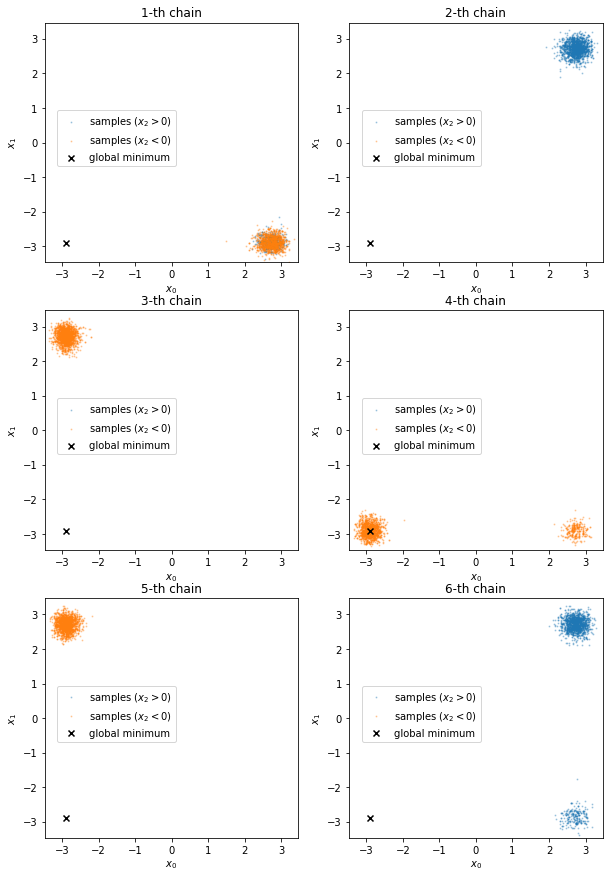

In [10]:
lim=abs(sample_j_n_k_c[:,0,burnin::skip,:]).max()
fig, axes = plt.subplots(
    figsize=(5*2, 5*3),
    nrows=3, ncols=2,
    sharex=False)
for chain in range(n_chain):
    axes[chain//2, chain%2].scatter(
        sample_j_n_k_c[chain, 0, burnin::skip, 0][sample_j_n_k_c[chain, 0, burnin::skip, 2]>0],
        sample_j_n_k_c[chain, 0, burnin::skip, 1][sample_j_n_k_c[chain, 0, burnin::skip, 2]>0],
        s=1, alpha=0.3, label=r"samples ($x_2>0$)"
    )
    axes[chain//2, chain%2].scatter(
        sample_j_n_k_c[chain, 0, burnin::skip, 0][sample_j_n_k_c[chain, 0, burnin::skip, 2]<0],
        sample_j_n_k_c[chain, 0, burnin::skip, 1][sample_j_n_k_c[chain, 0, burnin::skip, 2]<0],
        s=1, alpha=0.3, label=r"samples ($x_2<0$)"
    )
    axes[chain//2, chain%2].scatter([-2.903534], [-2.903534], c="k", marker="x", label="global minimum")
    axes[chain//2, chain%2].set_xlim(-lim, lim)
    axes[chain//2, chain%2].set_ylim(-lim, lim)
    axes[chain//2, chain%2].set_xlabel(r"$x_0$")
    axes[chain//2, chain%2].set_ylabel(r"$x_1$")
    axes[chain//2, chain%2].legend(loc=(0.05, 0.4))
    axes[chain//2, chain%2].set_title(f"{chain+1}-th chain")
plt.show()

chainごとに特定の谷付近にトラップされて抜け出せておらず，全体をサンプリングできていない．

## REMCMC

初期値は $(2.5, 2.5, 2.5)$ (一番遠い山)に取ってみる．

In [11]:
with open(glob.glob("test_remcmc_*.bin")[-1], mode="rb") as file:
    data = pickle.load(file)

sample_j_n_k = np.array(data["sample_j_n_k"])

k0 = abs(np.log10(data["beta_k"])).argmin()
burnin = 100
skip = 3

In [12]:
burnin = 5000
skip = 3

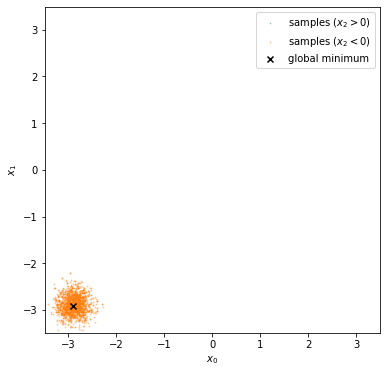

In [13]:
plt.figure(figsize=(6,6))
plt.scatter(
    sample_j_n_k[k0, burnin::skip, 0][sample_j_n_k[k0, burnin::skip, 2]>0],
    sample_j_n_k[k0, burnin::skip, 1][sample_j_n_k[k0, burnin::skip, 2]>0],
    s=1, alpha=0.3, label=r"samples ($x_2>0$)"
)
plt.scatter(
    sample_j_n_k[k0, burnin::skip, 0][sample_j_n_k[k0, burnin::skip, 2]<0],
    sample_j_n_k[k0, burnin::skip, 1][sample_j_n_k[k0, burnin::skip, 2]<0],
    s=1, alpha=0.3, label=r"samples ($x_2<0$)"
)
plt.scatter([-2.903534], [-2.903534], c="k", marker="x", label="global minimum")
lim = abs(np.array([*plt.xlim(), *plt.ylim()])).max()
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.xlabel(r"$x_0$")
plt.ylabel(r"$x_1$")
plt.legend()
plt.show()

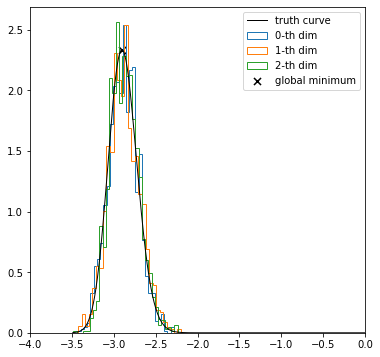

In [14]:
plt.figure(figsize=(6,6))
for d in range(3):
    plt.hist(
        sample_j_n_k[k0, burnin::skip, d],
        bins="auto", density=True, histtype="step",
        label=f"{d}-th dim"
    )
plt.plot(
    np.linspace(-lim, lim, 1000),
    f(np.linspace(-lim, lim, 1000)),
    color="k", linewidth=1,
    label=f"truth curve"
)
plt.scatter(
    [-2.903534], [f(-2.903534)],
    c="k", marker="x", s=50,
    label="global minimum")
plt.xlim(-4, 0)
plt.ylim(0, )
plt.legend()
plt.show()

遠い山から始めても正しいサンプリングができている(実際は事前分布の分ズレが生じる)．

$\beta$ による分布の変化

In [15]:
data["beta_k"]

array([1.00000000e-05, 3.16227766e-05, 1.00000000e-04, 3.16227766e-04,
       1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03, 3.16227766e+03, 1.00000000e+04, 3.16227766e+04,
       1.00000000e+05])

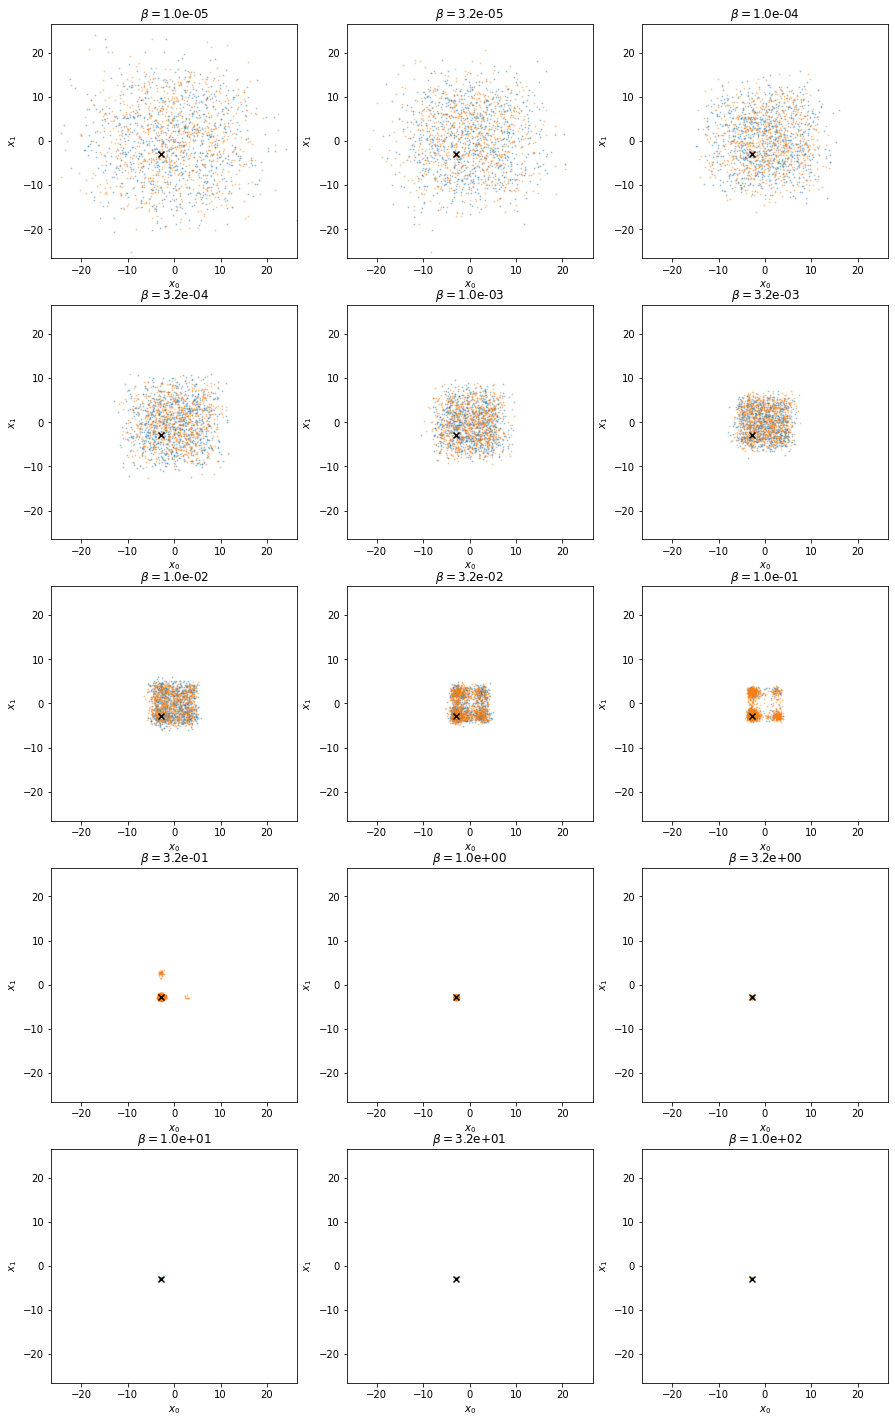

In [16]:
start, end = 0, 15
width = 3
height = -((- end + start)//width)
lim=abs(sample_j_n_k[0,burnin::skip,:]).max()
fig, axes = plt.subplots(
    figsize=(5*width, 5*height),
    nrows=height, ncols=width,
    sharex=False)
for k,beta in enumerate(data["beta_k"]):
    if k<start or k>=end: continue
    axes[(k-start)//width, k%width].scatter(
        sample_j_n_k[k, burnin::skip, 0][sample_j_n_k[k, burnin::skip, 2]>0],
        sample_j_n_k[k, burnin::skip, 1][sample_j_n_k[k, burnin::skip, 2]>0],
        s=1, alpha=0.3, label=r"samples ($x_2>0$)"
    )
    axes[(k-start)//width, k%width].scatter(
        sample_j_n_k[k, burnin::skip, 0][sample_j_n_k[k, burnin::skip, 2]<0],
        sample_j_n_k[k, burnin::skip, 1][sample_j_n_k[k, burnin::skip, 2]<0],
        s=1, alpha=0.3, label=r"samples ($x_2>0$)"
    )
    axes[(k-start)//width, k%width].scatter([-2.903534], [-2.903534], c="k", marker="x", label="global minimum")
    axes[(k-start)//width, k%width].set_xlim(-lim, lim)
    axes[(k-start)//width, k%width].set_ylim(-lim, lim)
    axes[(k-start)//width, k%width].set_xlabel(r"$x_0$")
    axes[(k-start)//width, k%width].set_ylabel(r"$x_1$")
    axes[(k-start)//width, k%width].set_title(r"$\beta=$"f"{beta:.1e}")
plt.show()

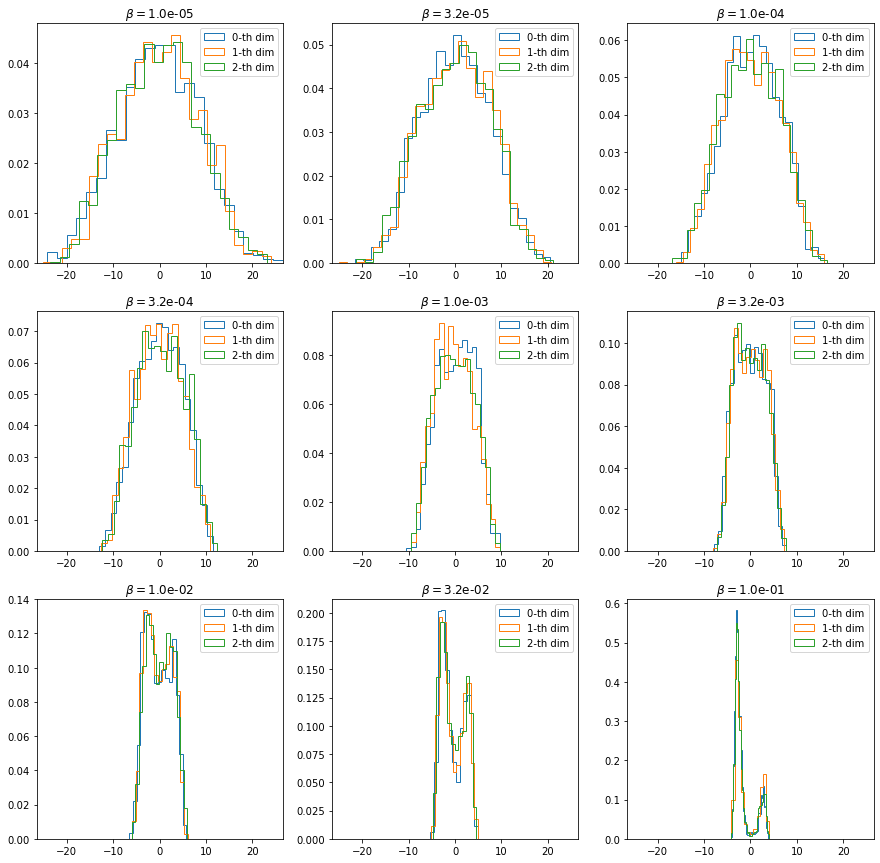

In [17]:
start, end = 0, 9
width = 3
height = -((- end + start)//width)
lim=abs(sample_j_n_k[0,burnin::skip,:]).max()
fig, axes = plt.subplots(
    figsize=(5*width, 5*height),
    nrows=height, ncols=width,
    sharex=False)
for k,beta in enumerate(data["beta_k"]):
    if k<start or k>=end: continue
    for d in range(3):
        axes[(k-start)//width, k%width].hist(
            sample_j_n_k[k, burnin::skip, d],
            bins="auto", density=True, histtype="step",
            label=f"{d}-th dim"
        )
    if k==k0:
        axes[(k-start)//width, k%width].plot(
            np.linspace(-lim, lim, 1000),
            f(np.linspace(-lim, lim, 1000)),
            color="k",
            label=f"truth curve"
        )
    axes[(k-start)//width, k%width].set_xlim(-lim, lim)
    axes[(k-start)//width, k%width].set_ylim(0, )
    axes[(k-start)//width, k%width].legend(loc="upper right")
    axes[(k-start)//width, k%width].set_title(r"$\beta=$"f"{beta:.1e}")
plt.show()

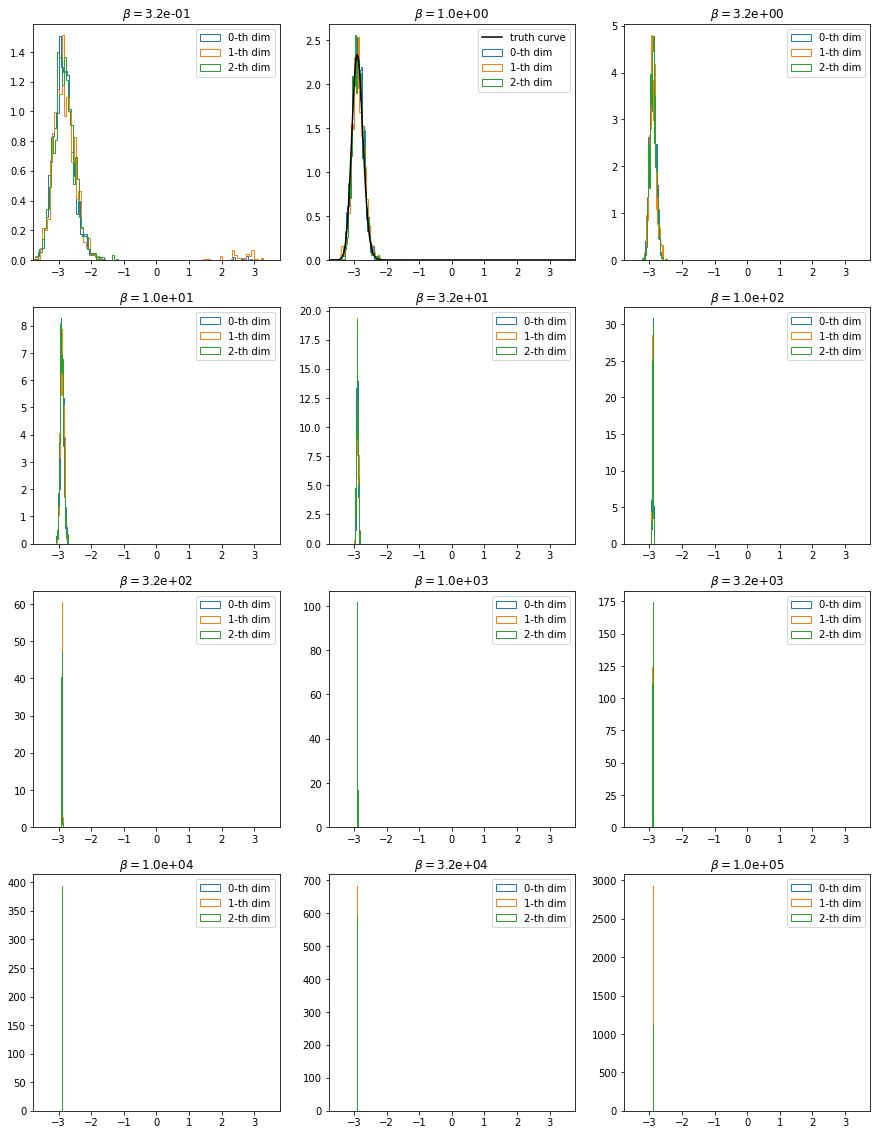

In [18]:
start, end = 9, 21
width = 3
height = -((- end + start)//width)
lim=abs(sample_j_n_k[9, burnin::skip,:]).max()
fig, axes = plt.subplots(
    figsize=(5*width, 5*height),
    nrows=height, ncols=width,
    sharex=False)
for k,beta in enumerate(data["beta_k"]):
    if k<start or k>=end: continue
    for d in range(3):
        axes[(k-start)//width, k%width].hist(
            sample_j_n_k[k, burnin::skip, d],
            bins="auto", density=True, histtype="step",
            label=f"{d}-th dim"
        )
    if k==k0:
        axes[(k-start)//width, k%width].plot(
            np.linspace(-lim, lim, 1000),
            f(np.linspace(-lim, lim, 1000)),
            color="k",
            label=f"truth curve"
        )
    axes[(k-start)//width, k%width].set_xlim(-lim, lim)
    axes[(k-start)//width, k%width].set_ylim(0, )
    axes[(k-start)//width, k%width].legend(loc="upper right")
    axes[(k-start)//width, k%width].set_title(r"$\beta=$"f"{beta:.1e}")
plt.show()

$\beta=0.1$ くらいのところでは $x<0, x>0$ 両方をとるなめらかな分布となっている  
$\beta=10^5$ ではほぼ大域解に集中している(≒最尤推定値)

In [19]:
for d in range(3):
    print(f"MAP estimation of x_{d}:",
          f"{sample_j_n_k[-1,burnin::skip,d].mean():.4f}"\
          f"±{sample_j_n_k[-1,burnin::skip,d].std():.4f}")

MAP estimation of x_0: -2.9033±0.0004
MAP estimation of x_1: -2.9034±0.0004
MAP estimation of x_2: -2.9036±0.0006
